In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

import zipfile
from io import BytesIO

In [2]:
import json
import base64
from io import BytesIO
import numpy as np
from PIL import Image
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

Start


In [20]:
def calculate_vviq_scores(vviq_data):
    def transform_score(score):
        score = int(score)
        if 0 <= score <= 4:
            return score + 1  # Transform 0-4 to 1-5
        else:
            raise ValueError(f"Invalid score: {score}. Expected 0-4.")

    scores_open = []
    scores_closed = []
    attention_checks = []

    for condition in ['open', 'closed']:
        for item in vviq_data[condition]:
            for key, value in item.items():
                if key.startswith('row'):
                    if key == 'row4' and item == vviq_data[condition][-1]:
                        # This is an attention check item
                        attention_checks.append(int(value))
                    else:
                        # This is a regular item
                        try:
                            transformed_score = transform_score(value)
                            if condition == 'open':
                                scores_open.append(transformed_score)
                            else:
                                scores_closed.append(transformed_score)
                        except ValueError as e:
                            print(f"Error in VVIQ data: {e}")

    # Ensure we have exactly 16 scores for each condition
    if len(scores_open) != 16 or len(scores_closed) != 16:
        print(f"Warning: Expected 16 VVIQ items for each condition, but found {len(scores_open)} (open) and {len(scores_closed)} (closed)")

    # Calculate scores
    absolute_score_open = sum(scores_open)
    absolute_score_closed = sum(scores_closed)
    absolute_score_total = absolute_score_open + absolute_score_closed

    normalized_score_open = (absolute_score_open - 16) / 64
    normalized_score_closed = (absolute_score_closed - 16) / 64
    normalized_score_total = (absolute_score_total - 32) / 128

    # Check if attention checks were passed
    attention_check_passed = all(check == 4 for check in attention_checks)

    return {
        'absolute_score_open': absolute_score_open,
        'absolute_score_closed': absolute_score_closed,
        'absolute_score_total': absolute_score_total,
        'normalized_score_open': normalized_score_open,
        'normalized_score_closed': normalized_score_closed,
        'normalized_score_total': normalized_score_total,
        'attention_check_passed': attention_check_passed,
        'num_items_open': len(scores_open),
        'num_items_closed': len(scores_closed)
    }

In [29]:
def calculate_caps_scores(responses):
    # Initialize scores
    total_caps_score = 0
    visual_caps_score = 0
    distress_score = 0
    distracting_score = 0
    frequency_score = 0
    visual_distress_score = 0
    visual_distracting_score = 0
    visual_frequency_score = 0
    
    # Visual perception items
    visual_questions = [4, 19, 22, 23, 26, 31]
    
    for response in responses:
        question_number = response['question_number']
        if response['response'] == 'yes':
            total_caps_score += 1
            
            # Add subscale scores if available
            if 'subscale' in response:
                distress_score += int(response['subscale']['subscale_0'])
                distracting_score += int(response['subscale']['subscale_1'])
                frequency_score += int(response['subscale']['subscale_2'])
            
            # Check if it's a visual perception question
            if question_number in visual_questions:
                visual_caps_score += 1
                if 'subscale' in response:
                    visual_distress_score += int(response['subscale']['subscale_0'])
                    visual_distracting_score += int(response['subscale']['subscale_1'])
                    visual_frequency_score += int(response['subscale']['subscale_2'])
    
    return {
        'total_caps_score': total_caps_score,
        'visual_caps_score': visual_caps_score,
        'total_distress_score': distress_score,
        'total_distracting_score': distracting_score,
        'total_frequency_score': frequency_score,
        'visual_distress_score': visual_distress_score,
        'visual_distracting_score': visual_distracting_score,
        'visual_frequency_score': visual_frequency_score,
        'total_dimensional_score': distress_score + distracting_score + frequency_score,
        'visual_dimensional_score': visual_distress_score + visual_distracting_score + visual_frequency_score
    }

In [30]:
def preprocess_participant_data(participant_data):
    # Extract demographic data
    demographics = participant_data['demographics']
    
    # Process VVIQ data
    vviq_data = participant_data['vviq']
    vviq_scores = calculate_vviq_scores(vviq_data)
    
    # Process CAPS data
    caps_data = participant_data['caps']
    caps_scores = calculate_caps_scores(caps_data)
    
    # Process training trials
    training_trials = [trial for trial in participant_data['trials'] if trial.get('trial_type') == 'training']
    correct_training_trials = sum(1 for trial in training_trials if trial.get('correct', False))
    training_accuracy = (correct_training_trials / len(training_trials)) * 100 if training_trials else 0
    training_condition = training_trials[0]['condition'] if training_trials else None
    
    # Process main experiment trials
    main_trials = [trial for trial in participant_data['trials'] if 'block_number' in trial]
    main_condition = main_trials[0]['condition'] if main_trials else None
    
    # Extract images
    training_images = [decode_base64_image(trial['stimuli'][trial['selected_index']]) for trial in training_trials]
    
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}
    for trial in main_trials:
        block = trial['block_number']
        for stimulus in trial['stimuli']:
            img = decode_base64_image(stimulus['dataURL'])
            if stimulus['selected']:
                selected_images[block].append(img)
            else:
                non_selected_images[block].append(img)
    
    return {
        'participant_id': participant_data['participant_id'],
        'demographics': demographics,
        'vviq_scores': vviq_scores,
        'caps_scores': caps_scores,
        'training_accuracy': training_accuracy,
        'training_condition': training_condition,
        'main_condition': main_condition,
        'training_images': training_images,
        'selected_images': selected_images,
        'non_selected_images': non_selected_images
    }

In [31]:
def create_summary_dataframe(all_participants_data):
    summary_data = []
    for participant_id, data in all_participants_data.items():
        summary_data.append({
            'participant_id': participant_id,
            'age': data['demographics']['age'],
            'gender': data['demographics']['gender'],
            'vviq_absolute_score_open': data['vviq_scores']['absolute_score_open'],
            'vviq_absolute_score_closed': data['vviq_scores']['absolute_score_closed'],
            'vviq_absolute_score_total': data['vviq_scores']['absolute_score_total'],
            'vviq_normalized_score_open': data['vviq_scores']['normalized_score_open'],
            'vviq_normalized_score_closed': data['vviq_scores']['normalized_score_closed'],
            'vviq_normalized_score_total': data['vviq_scores']['normalized_score_total'],
            'vviq_attention_check_passed': data['vviq_scores']['attention_check_passed'],
            'vviq_num_items_open': data['vviq_scores']['num_items_open'],
            'vviq_num_items_closed': data['vviq_scores']['num_items_closed'],
            'caps_total_score': data['caps_scores']['total_caps_score'],
            'caps_visual_score': data['caps_scores']['visual_caps_score'],
            'caps_total_distress_score': data['caps_scores']['total_distress_score'],
            'caps_total_distracting_score': data['caps_scores']['total_distracting_score'],
            'caps_total_frequency_score': data['caps_scores']['total_frequency_score'],
            'caps_visual_distress_score': data['caps_scores']['visual_distress_score'],
            'caps_visual_distracting_score': data['caps_scores']['visual_distracting_score'],
            'caps_visual_frequency_score': data['caps_scores']['visual_frequency_score'],
            'caps_total_dimensional_score': data['caps_scores']['total_dimensional_score'],
            'caps_visual_dimensional_score': data['caps_scores']['visual_dimensional_score'],
            'training_accuracy': data['training_accuracy'],
            'training_condition': data['training_condition'],
            'main_condition': data['main_condition'],
            'num_selected_block1': len(data['selected_images'][1]),
            'num_selected_block2': len(data['selected_images'][2])
        })
    return pd.DataFrame(summary_data)

In [32]:
def load_and_preprocess_data(file_path):
    all_participants_data = {}
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as file:
                    participant_data = json.load(file)
                    processed_data = preprocess_participant_data(participant_data)
                    all_participants_data[processed_data['participant_id']] = processed_data
    return all_participants_data

In [33]:
# Load and preprocess data
file_path = 'jatos_results_20241104145840.jrzip'
all_participants_data = load_and_preprocess_data(file_path)

# Create summary dataframe
summary_df = create_summary_dataframe(all_participants_data)

# Display summary statistics
print(summary_df.describe())
print("\nParticipant Summary:")
print(summary_df)

             age  vviq_absolute_score_open  vviq_absolute_score_closed  \
count   6.000000                  6.000000                    6.000000   
mean   24.833333                 34.833333                   45.500000   
std     7.413951                 12.254251                   23.373061   
min    18.000000                 22.000000                   20.000000   
25%    21.000000                 24.250000                   26.250000   
50%    21.500000                 34.500000                   45.000000   
75%    27.250000                 42.500000                   58.500000   
max    38.000000                 52.000000                   80.000000   

       vviq_absolute_score_total  vviq_normalized_score_open  \
count                   6.000000                    6.000000   
mean                   80.333333                    0.294271   
std                    31.007526                    0.191473   
min                    43.000000                    0.093750   
25%          

In [34]:
def display_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title)
    for i, img in enumerate(images):
        if len(images) > 1:
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes.imshow(img)
            axes.axis('off')
    plt.show()

def display_results(all_participants_data):
    for participant_id, data in all_participants_data.items():
        print(f"\nParticipant ID: {participant_id}")
        print(f"Training Condition: {data['training_condition']}")
        print(f"Main Experiment Condition: {data['main_condition']}")
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        fig.suptitle(f"Participant {participant_id} Composites", fontsize=16)
        
        axes[0, 0].imshow(data['composites']['training'], cmap='gray')
        axes[0, 0].set_title('Training Composite')
        
        axes[0, 1].imshow(data['composites']['block1'], cmap='gray')
        axes[0, 1].set_title('Block 1 Composite')
        
        axes[1, 0].imshow(data['composites']['block2'], cmap='gray')
        axes[1, 0].set_title('Block 2 Composite')
        
        axes[1, 1].imshow(data['composites']['all'], cmap='gray')
        axes[1, 1].set_title('All Blocks Composite')
        
        for ax in axes.flat:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [35]:
def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

def analyze_participant(participant_data):
    # Create composites
    training_composite = create_composite_image(participant_data['training_images'])
    selected_composites = {
        block: create_composite_image(images) 
        for block, images in participant_data['selected_images'].items()
    }
    non_selected_composites = {
        block: create_composite_image(images) 
        for block, images in participant_data['non_selected_images'].items()
    }
    
    # Create enhanced composites
    enhanced_composites = {
        block: selected_composites[block] - non_selected_composites[block]
        for block in selected_composites.keys()
    }
    
    return {
        'training_composite': training_composite,
        'selected_composites': selected_composites,
        'non_selected_composites': non_selected_composites,
        'enhanced_composites': enhanced_composites
    }

# Analyze data for a specific participant
participant_id = list(all_participants_data.keys())[0]  # Just an example
analysis_results = analyze_participant(all_participants_data[participant_id])

# You can now visualize these results or perform further analysis

In [41]:
def inspect_data_structure(data):
    """Inspect and print the structure of the participant data."""
    print("Keys in participant data:")
    for key in data.keys():
        print(f"- {key}")
        if isinstance(data[key], dict):
            print("  Subkeys:")
            for subkey in data[key].keys():
                print(f"  - {subkey}")
    
    # Check for specific keys we're interested in
    if 'trials' in data:
        print("\nStructure of a trial:")
        trial = data['trials'][0]  # Assuming at least one trial exists
        for key in trial.keys():
            print(f"- {key}")

def extract_images(data):
    """Extract images from the data structure."""
    training_images = []
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}

    for trial in data['trials']:
        if trial.get('trial_type') == 'training':
            training_images.append(decode_base64_image(trial['stimuli'][trial['selected_index']]))
        elif 'block_number' in trial:
            block = trial['block_number']
            selected_index = trial['selected_index']
            for i, stimulus in enumerate(trial['stimuli']):
                img = decode_base64_image(stimulus['dataURL'])
                if i == selected_index:
                    selected_images[block].append(img)
                else:
                    non_selected_images[block].append(img)

    return training_images, selected_images, non_selected_images


def analyze_participant(participant_data):
    training_images, selected_images, non_selected_images = extract_images(participant_data)
    
    training_composite = create_composite_image(training_images)
    
    selected_composites = {
        block: create_composite_image(images) 
        for block, images in selected_images.items()
    }
    
    # Create block 1+2 composite
    all_selected_images = selected_images[1] + selected_images[2]
    selected_composites['1+2'] = create_composite_image(all_selected_images)
    
    # Create enhanced composites
    enhanced_composites = {}
    for block in [1, 2]:
        enhanced_composites[block] = create_enhanced_composite(
            selected_images[block],
            [non_selected_images[block][i:i+9] for i in range(0, len(non_selected_images[block]), 9)]
        )
    
    # Create block 1+2 enhanced composite
    all_selected = selected_images[1] + selected_images[2]
    all_non_selected = non_selected_images[1] + non_selected_images[2]
    enhanced_composites['1+2'] = create_enhanced_composite(
        all_selected,
        [all_non_selected[i:i+9] for i in range(0, len(all_non_selected), 9)]
    )
    
    return {
        'training_composite': training_composite,
        'selected_composites': selected_composites,
        'enhanced_composites': enhanced_composites,
        'target_digit': participant_data['trials'][0]['condition']  # Assuming condition is the same for all trials
    }

# Main execution
for participant_id, data in all_participants_data.items():
    print(f"\nInspecting data for participant {participant_id}")
    inspect_data_structure(data)
    
    try:
        results = analyze_participant(data)
        display_results(participant_id, results)
    except Exception as e:
        print(f"Error processing participant {participant_id}: {str(e)}")


Inspecting data for participant d
Keys in participant data:
- participant_id
- demographics
  Subkeys:
  - age
  - gender
- vviq_scores
  Subkeys:
  - absolute_score_open
  - absolute_score_closed
  - absolute_score_total
  - normalized_score_open
  - normalized_score_closed
  - normalized_score_total
  - attention_check_passed
  - num_items_open
  - num_items_closed
- caps_scores
  Subkeys:
  - total_caps_score
  - visual_caps_score
  - total_distress_score
  - total_distracting_score
  - total_frequency_score
  - visual_distress_score
  - visual_distracting_score
  - visual_frequency_score
  - total_dimensional_score
  - visual_dimensional_score
- training_accuracy
- training_condition
- main_condition
- training_images
- selected_images
  Subkeys:
  - 1
  - 2
- non_selected_images
  Subkeys:
  - 1
  - 2
Error processing participant d: 'trials'

Inspecting data for participant 88755
Keys in participant data:
- participant_id
- demographics
  Subkeys:
  - age
  - gender
- vviq_scores

Processing participant d


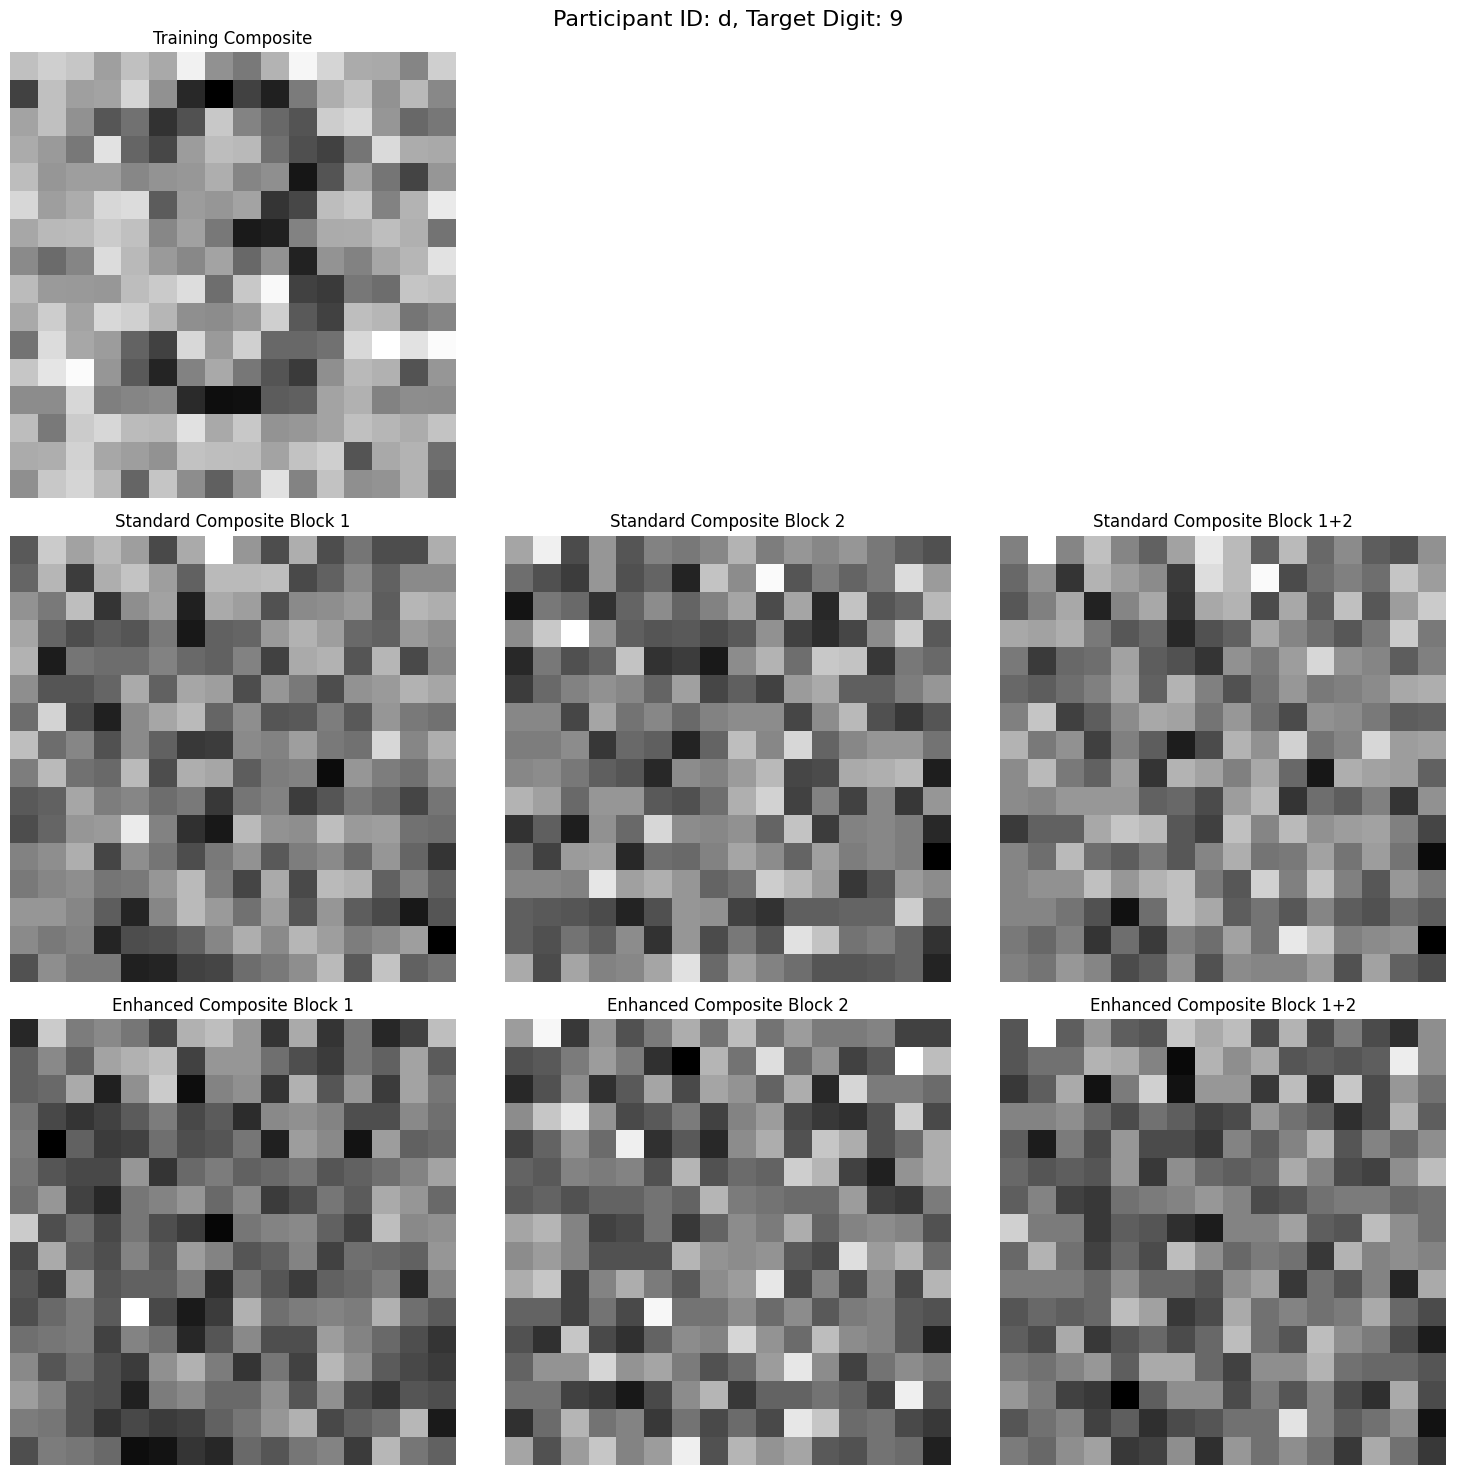

Processing participant 88755


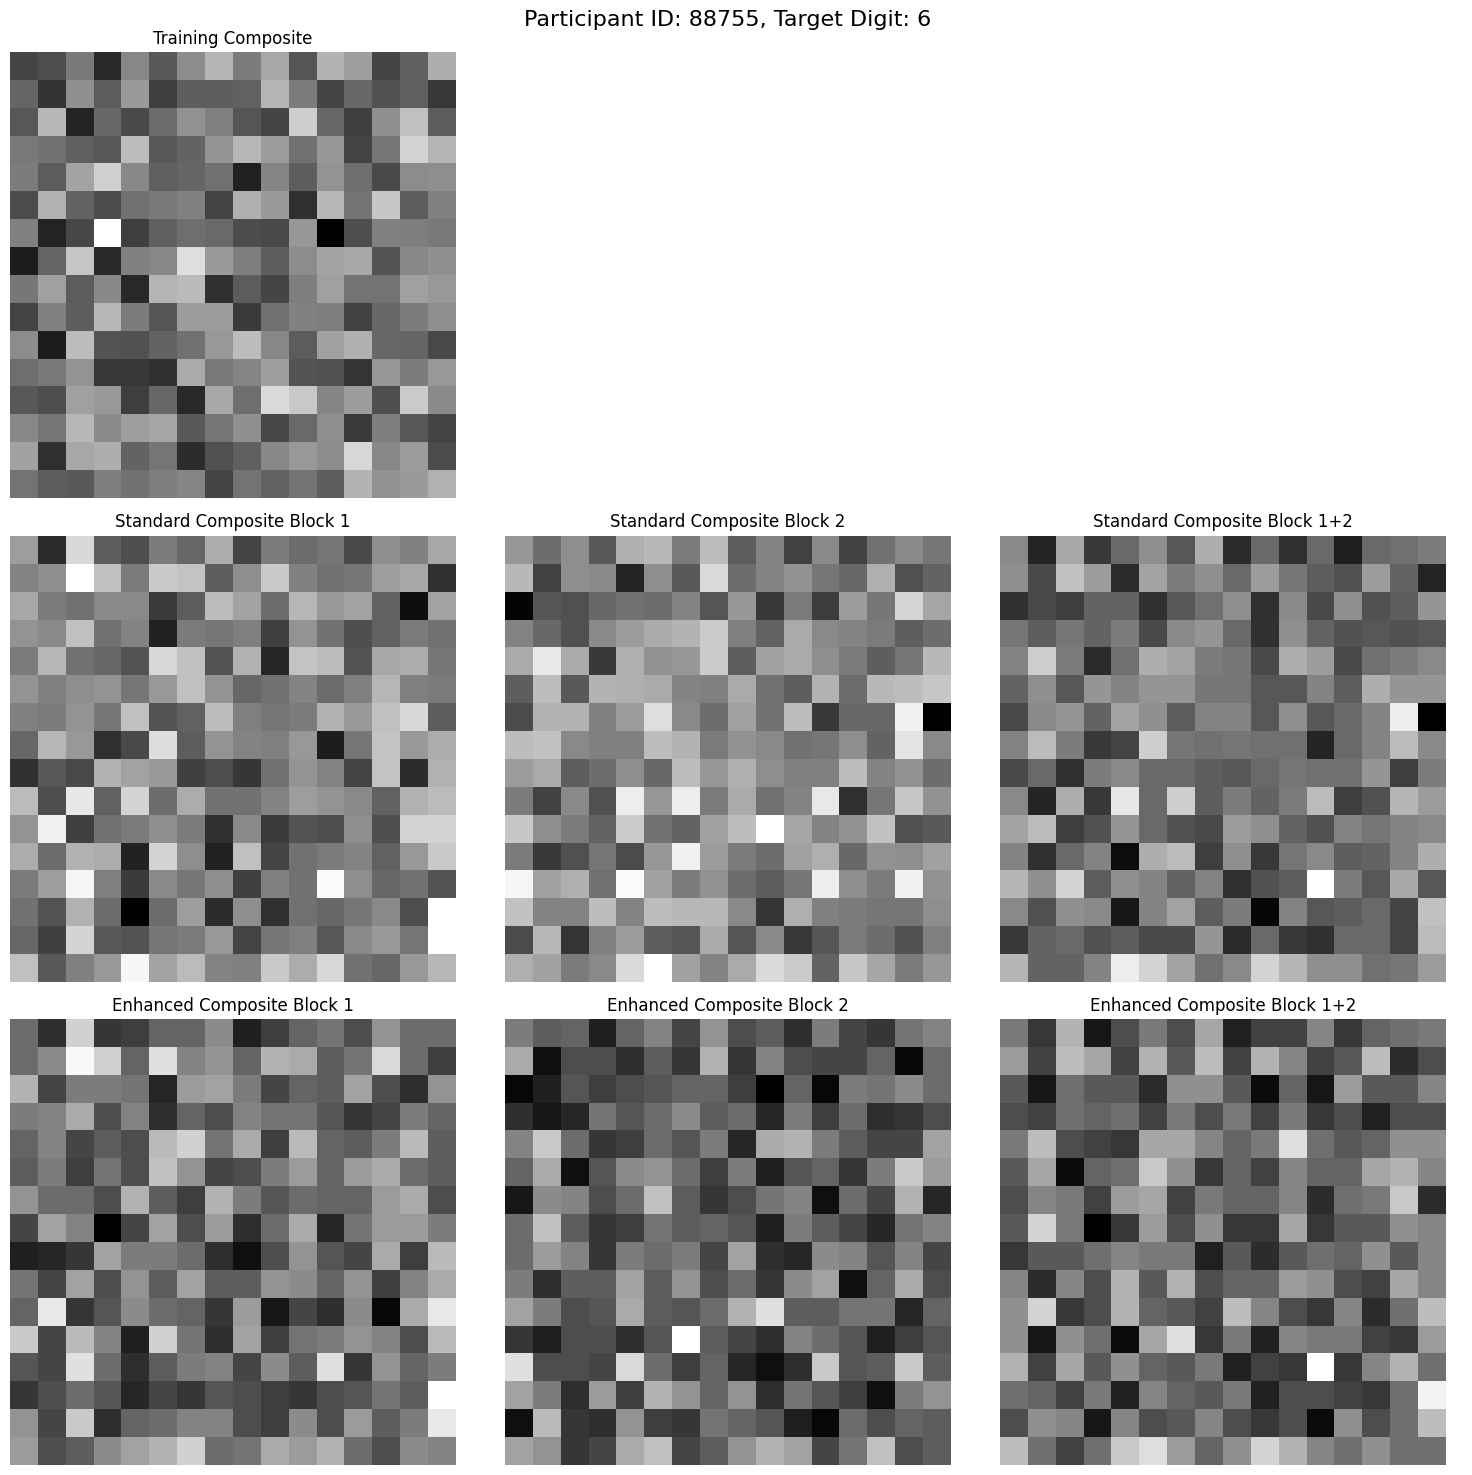

Processing participant 275555


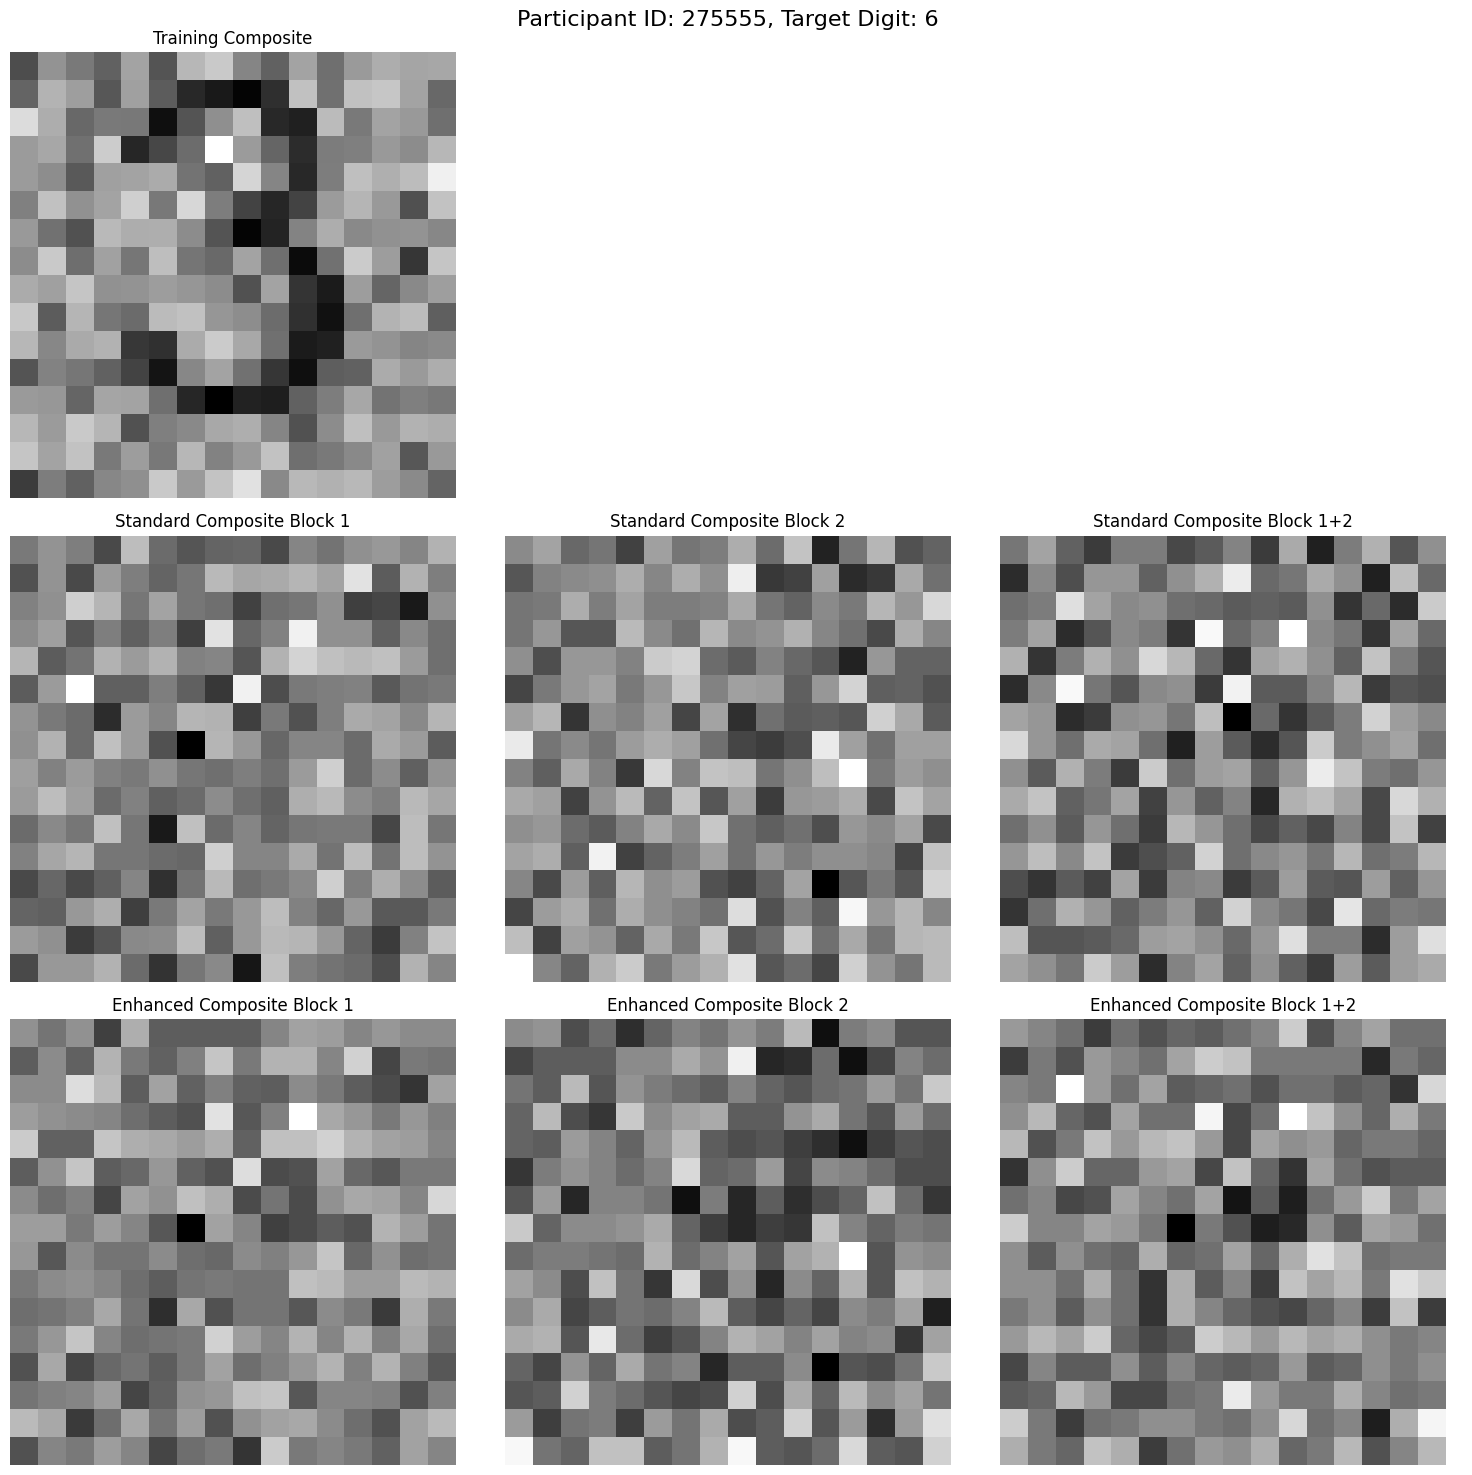

Processing participant tyl2g22


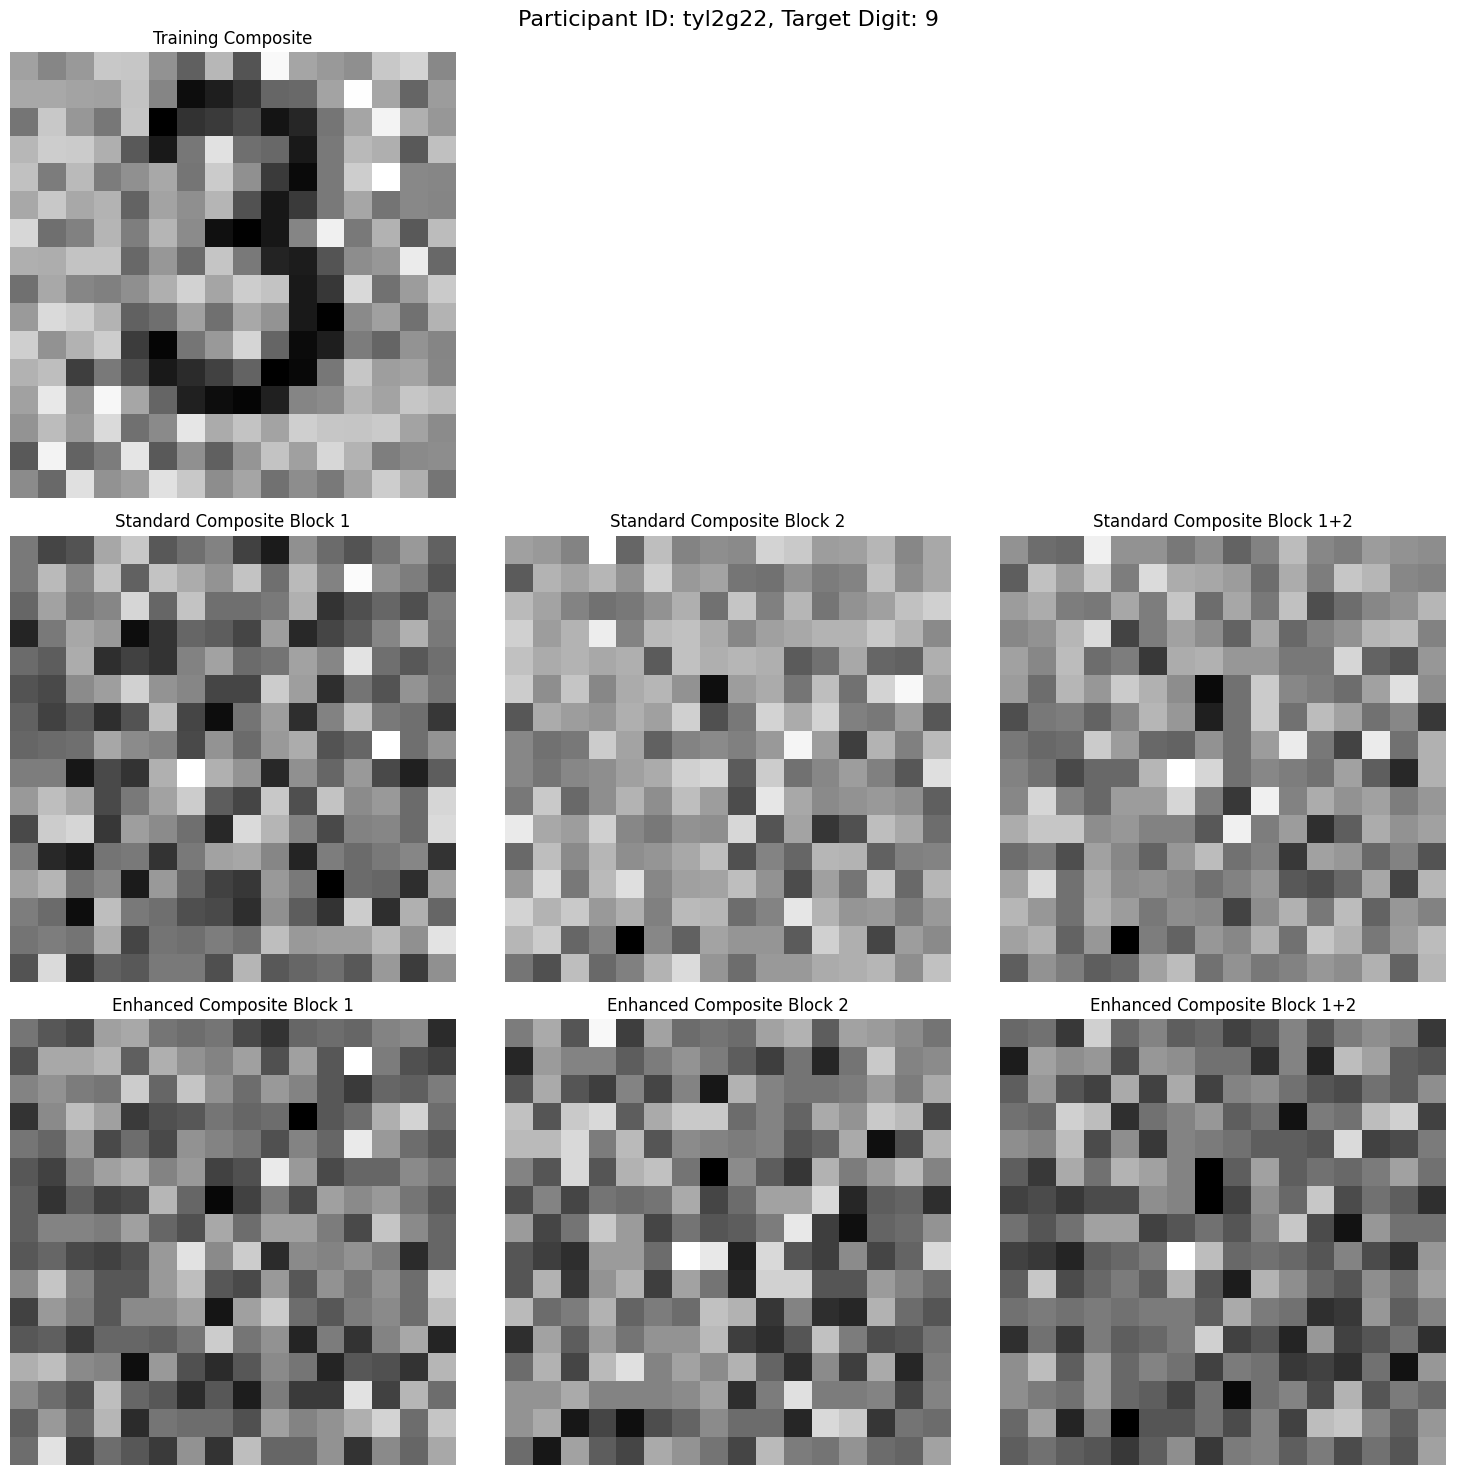

Processing participant ab8n22


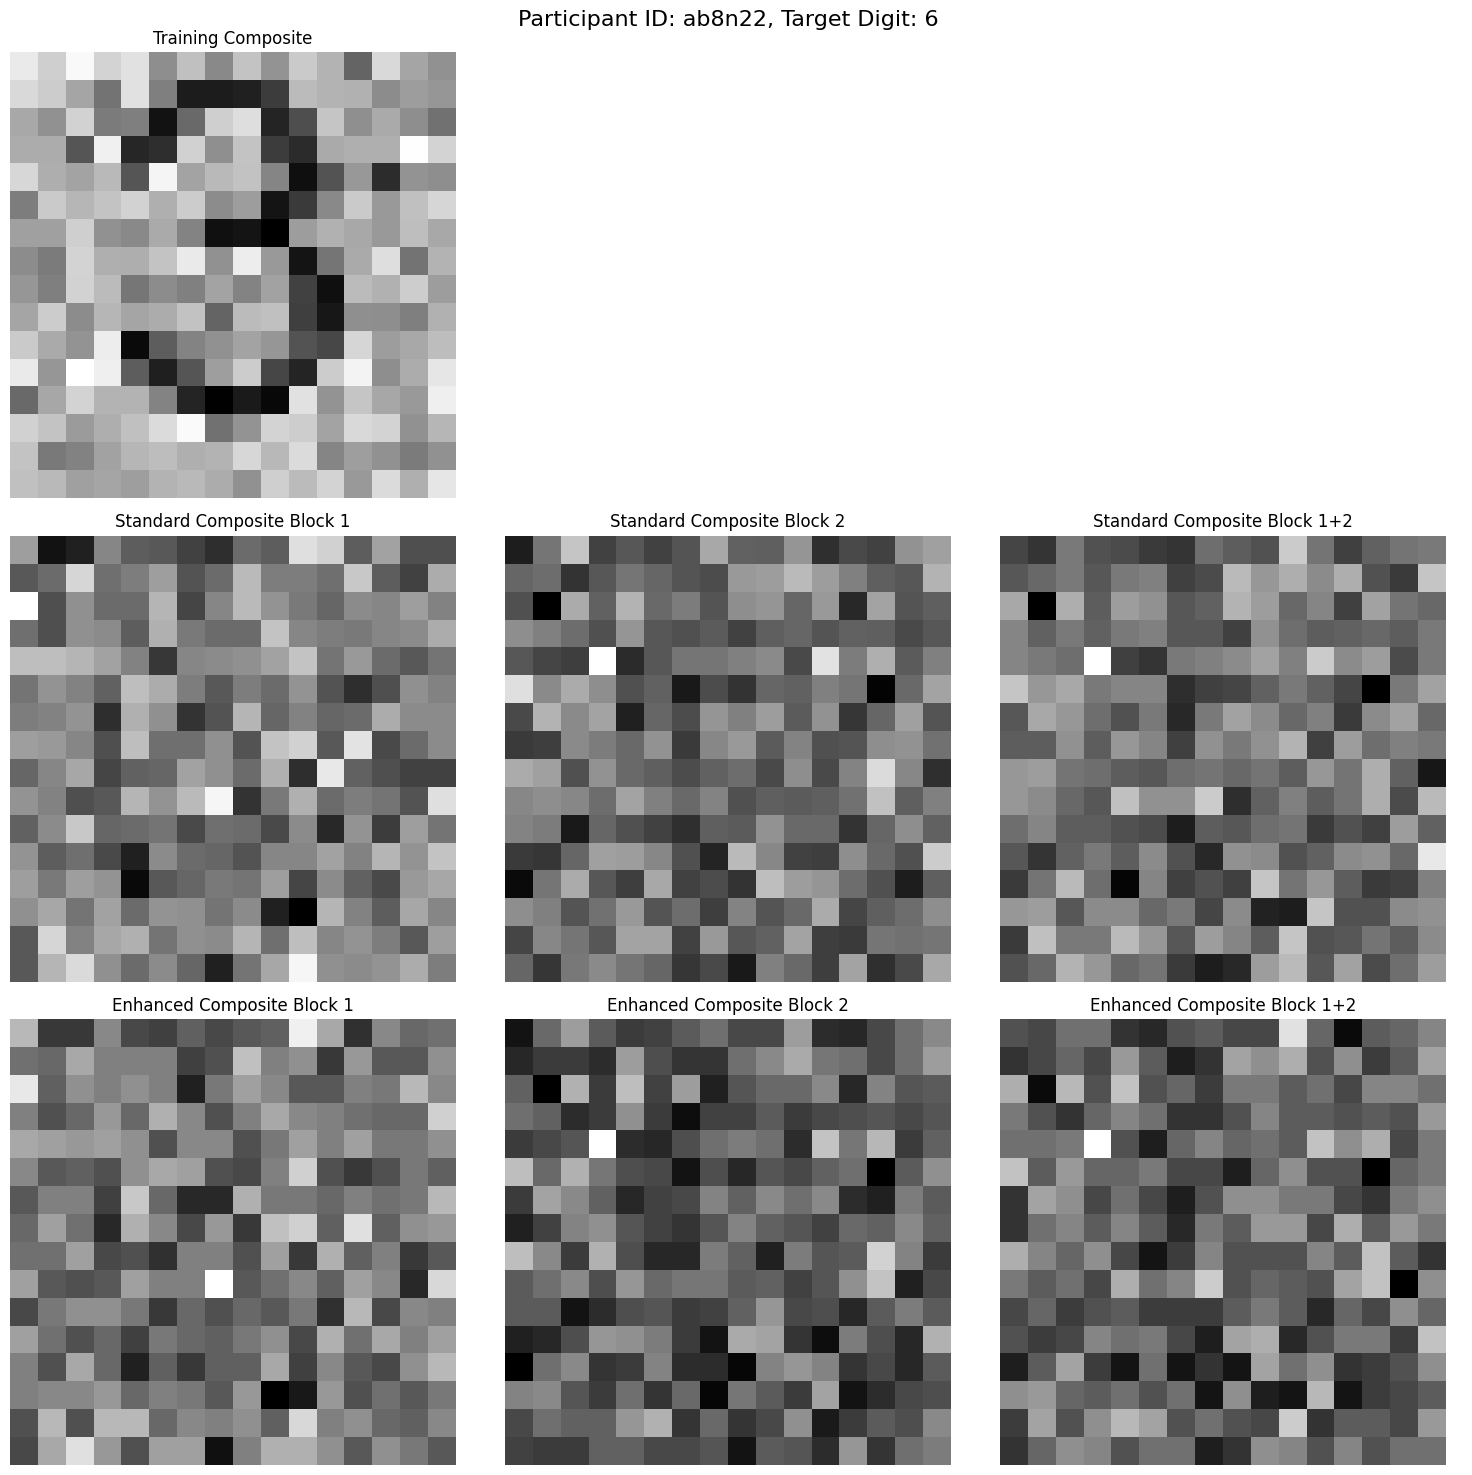

Processing participant 110424


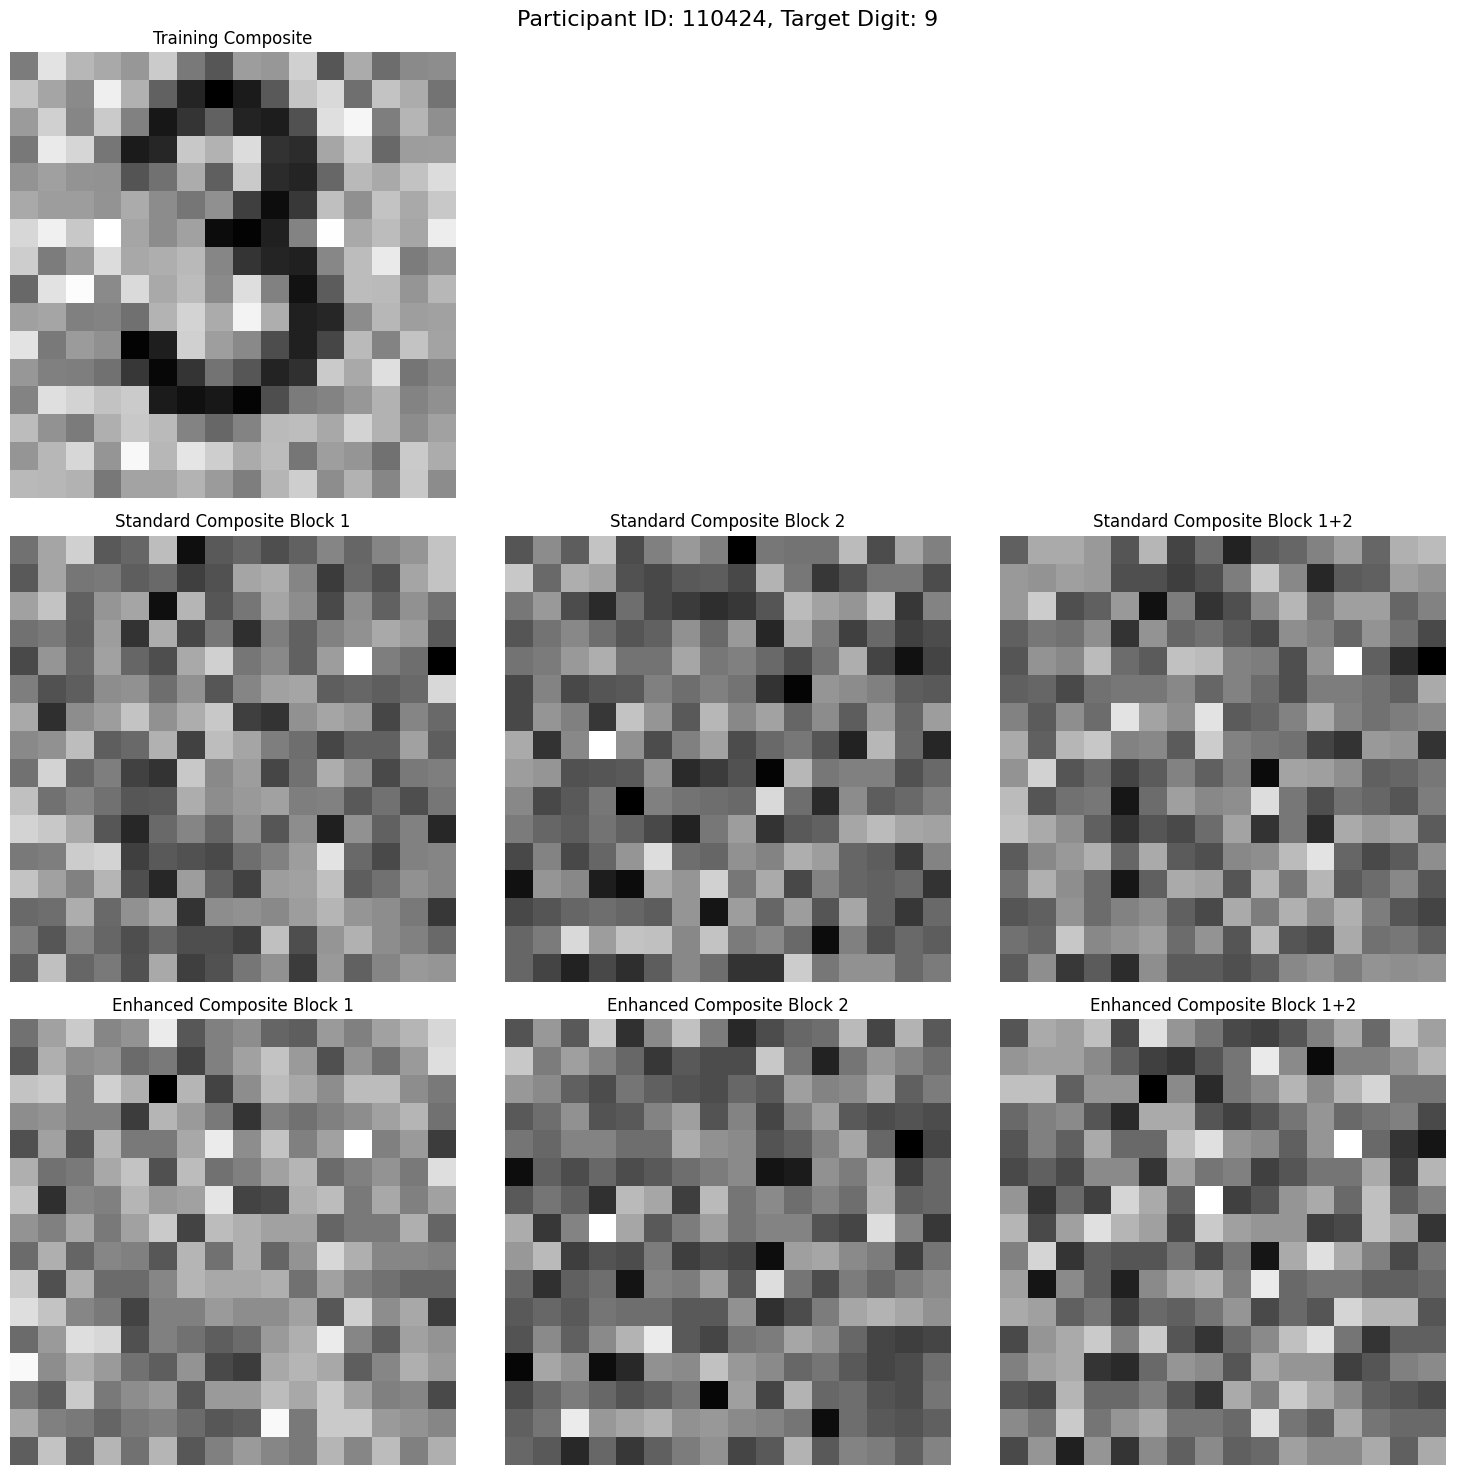

In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

def create_enhanced_composite(selected_images, non_selected_images):
    enhanced_trials = []
    for selected, non_selected_set in zip(selected_images, non_selected_images):
        selected_array = np.array(selected.convert('L').resize((16, 16)))
        non_selected_arrays = [np.array(img.convert('L').resize((16, 16))) for img in non_selected_set]
        avg_non_selected = np.mean(non_selected_arrays, axis=0)
        enhanced_trial = selected_array.astype(np.int16) - avg_non_selected.astype(np.int16)
        enhanced_trials.append(np.clip(enhanced_trial, 0, 255).astype(np.uint8))
    return np.mean(enhanced_trials, axis=0).astype(np.uint8)

def analyze_participant(participant_data):
    # Create training composite
    training_composite = create_composite_image(participant_data['training_images'])
    
    # Create standard composites
    standard_composites = {}
    enhanced_composites = {}
    
    for block in [1, 2]:
        selected = participant_data['selected_images'][block]
        non_selected = participant_data['non_selected_images'][block]
        
        # Standard composite
        standard_composites[block] = create_composite_image(selected)
        
        # Enhanced composite
        non_selected_reshaped = [non_selected[i:i+9] for i in range(0, len(non_selected), 9)]
        enhanced_composites[block] = create_enhanced_composite(selected, non_selected_reshaped)
    
    # Create block 1+2 composites
    all_selected = participant_data['selected_images'][1] + participant_data['selected_images'][2]
    all_non_selected = participant_data['non_selected_images'][1] + participant_data['non_selected_images'][2]
    
    standard_composites['1+2'] = create_composite_image(all_selected)
    
    all_non_selected_reshaped = [all_non_selected[i:i+9] for i in range(0, len(all_non_selected), 9)]
    enhanced_composites['1+2'] = create_enhanced_composite(all_selected, all_non_selected_reshaped)
    
    return {
        'training_composite': training_composite,
        'standard_composites': standard_composites,
        'enhanced_composites': enhanced_composites,
        'target_digit': participant_data['main_condition']
    }

def display_results(participant_id, results):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f"Participant ID: {participant_id}, Target Digit: {results['target_digit']}", fontsize=16)
    
    axes[0, 0].imshow(results['training_composite'], cmap='gray')
    axes[0, 0].set_title('Training Composite')
    
    for i, block in enumerate([1, 2, '1+2']):
        axes[1, i].imshow(results['standard_composites'][block], cmap='gray')
        axes[1, i].set_title(f'Standard Composite Block {block}')
        
        axes[2, i].imshow(results['enhanced_composites'][block], cmap='gray')
        axes[2, i].set_title(f'Enhanced Composite Block {block}')
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
# Main execution
for participant_id, data in all_participants_data.items():
    try:
        print(f"Processing participant {participant_id}")
        results = analyze_participant(data)
        display_results(participant_id, results)
    except Exception as e:
        print(f"Error processing participant {participant_id}: {str(e)}")
        print(f"Available keys for participant {participant_id}: {data.keys()}")
        # Print more detailed information about the data structure
        for key in data.keys():
            if isinstance(data[key], dict):
                print(f"{key}: {data[key].keys()}")
            elif isinstance(data[key], list):
                print(f"{key}: List of length {len(data[key])}")
            else:
                print(f"{key}: {type(data[key])}")

### Standard Composites

1. **For each block (1 and 2):**
   - We take all the selected images for that block.
   - We use the `create_composite_image` function, which does the following:
     a. Converts each image to grayscale and resizes it to 16x16 pixels.
     b. Converts each image to a numpy array.
     c. Stacks all these arrays.
     d. Calculates the mean across all images (pixel by pixel).
     e. Converts the result back to an 8-bit unsigned integer array.

2. **For the combined block 1+2:**
   - We concatenate the selected images from block 1 and block 2.
   - We then apply the same process as above to this combined list of images.

The standard composite is essentially an average of all selected images, representing the "typical" image chosen by the participant.

### Enhanced Composites

1. **For each block (1 and 2):**
   - We take all the selected images and all the non-selected images for that block.
   - We reshape the non-selected images into groups of 9 (as there should be 9 non-selected images for each selected image).
   - We then use the `create_enhanced_composite` function, which does the following for each trial:
     a. Convert the selected image to a 16x16 grayscale numpy array.
     b. Convert each of the 9 non-selected images to 16x16 grayscale numpy arrays.
     c. Calculate the average of the 9 non-selected images.
     d. Subtract this average non-selected image from the selected image.
     e. Clip the result to ensure values are between 0 and 255.
   - After processing all trials, we average all these enhanced trial images.

2. **For the combined block 1+2:**
   - We concatenate the selected images and non-selected images from both blocks.
   - We then apply the same process as above to this combined data.

The enhanced composite emphasizes the unique features of the selected images by subtracting out the "background noise" represented by the non-selected images. This process should theoretically highlight the key features that the participant is using to make their selections.

### Logical Soundness

This approach is logically sound because:

1. **Standard Composites:** By averaging all selected images, we get a representation of the "typical" image that the participant chose. This helps visualize any consistent patterns in their selections.

2. **Enhanced Composites:** By subtracting the average of non-selected images from each selected image, we're essentially removing the common features present in all images and highlighting what's unique about the selected images. This process is done on a trial-by-trial basis before averaging, which should preserve trial-specific enhancements.

3. **Block 1+2 Composites:** By combining data from both blocks, we get an overall representation of the participant's choices across the entire experiment, which can reveal more stable patterns.

4. **Image Processing:** All images are consistently processed (grayscale, 16x16 resize) to ensure comparability.

5. **Averaging:** The use of averaging helps to reduce noise and emphasize consistent patterns across trials and blocks.

This approach should provide a good visualization of the patterns in the participant's image selections, both in terms of what they typically chose (standard composites) and what unique features guided their choices (enhanced composites).

let's look at some basic correlations

Correlations:
                           vviq_absolute_score_total  caps_total_score  \
vviq_absolute_score_total                   1.000000         -0.441116   
caps_total_score                           -0.441116          1.000000   
caps_visual_score                          -0.618807          0.610170   
training_accuracy                           0.551882          0.309774   

                           caps_visual_score  training_accuracy  
vviq_absolute_score_total          -0.618807           0.551882  
caps_total_score                    0.610170           0.309774  
caps_visual_score                   1.000000          -0.197101  
training_accuracy                  -0.197101           1.000000  

P-values:
                          vviq_absolute_score_total caps_total_score  \
vviq_absolute_score_total                       NaN         0.381243   
caps_total_score                           0.381243              NaN   
caps_visual_score                          0.190267       

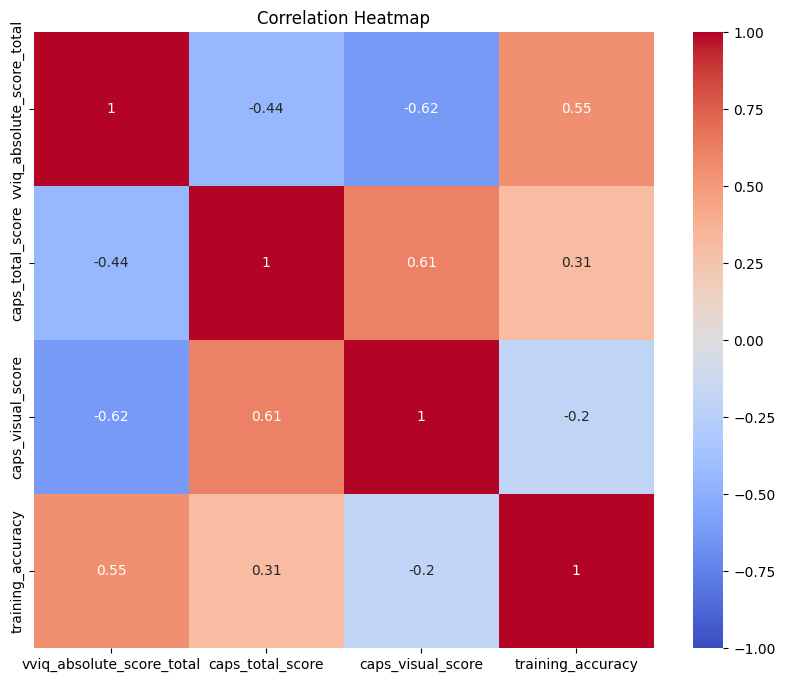


Specific Correlations of Interest:
VVIQ vs Overall CAPS:
  Correlation coefficient: -0.4411
  p-value: 0.3812

VVIQ vs Visual CAPS:
  Correlation coefficient: -0.6188
  p-value: 0.1903

VVIQ vs Training Accuracy:
  Correlation coefficient: 0.5519
  p-value: 0.2562

Overall CAPS vs Training Accuracy:
  Correlation coefficient: 0.3098
  p-value: 0.5502



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_correlations(summary_df):
    # Define the variables we want to correlate
    variables = ['vviq_absolute_score_total', 'caps_total_score', 'caps_visual_score', 'training_accuracy']
    
    # Create a correlation matrix
    corr_matrix = summary_df[variables].corr()
    
    # Calculate p-values
    p_values = pd.DataFrame(columns=variables, index=variables)
    for i in variables:
        for j in variables:
            if i != j:
                _, p = stats.pearsonr(summary_df[i], summary_df[j])
                p_values.loc[i, j] = p
    
    # Print correlations and p-values
    print("Correlations:")
    print(corr_matrix)
    print("\nP-values:")
    print(p_values)
    
    # Create a heatmap of correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Specific correlations of interest
    correlations_of_interest = [
        ('VVIQ', 'Overall CAPS', 'vviq_absolute_score_total', 'caps_total_score'),
        ('VVIQ', 'Visual CAPS', 'vviq_absolute_score_total', 'caps_visual_score'),
        ('VVIQ', 'Training Accuracy', 'vviq_absolute_score_total', 'training_accuracy'),
        ('Overall CAPS', 'Training Accuracy', 'caps_total_score', 'training_accuracy')
    ]
    
    print("\nSpecific Correlations of Interest:")
    for corr in correlations_of_interest:
        r, p = stats.pearsonr(summary_df[corr[2]], summary_df[corr[3]])
        print(f"{corr[0]} vs {corr[1]}:")
        print(f"  Correlation coefficient: {r:.4f}")
        print(f"  p-value: {p:.4f}")
        print()

# Usage:
# Assuming you have already created your summary_df
analyze_correlations(summary_df)

Now let's look at some classifications